# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 1: Customer Segmentation Report

Despite the extensive literature on market segmentation, there is no overall
consensus about the optimal segmentation methodology. One reason for this
diversity is the fact that segmentation can be observed from different
perspectives.

The challenge in the first part of this project is aimed at making use of machine
learning techniques in grouping customers regarding their demographics
characteristics and secondly try to group them regarding their geographical
location in Germany.

In this section, the main subjects are divided as follows:

1. Data Exploration
2. Cleaning Data
3. Principle Component Analysis (PCA)

### 1- Data Exploration

Data exploration is essential to understand the problem. It is not possible to achieve effective results without having enough knowledge about the data. Before using data, we must know more about it. It is necessary to analyze the data before applying machine learning techniques. There are some data analysis tools that facilitate this. We present some of these techniques that were applied to explore our data.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.info()#Demographics data for the general population of Germany

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()#Demographics data for customers of a mail-order company

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [5]:
print ('azdias dataset contains {} rows and {} columns'.format(azdias.shape[0],azdias.shape[1]))
print ('customers dataset contains {} rows and {} columns'.format(customers.shape[0],customers.shape[1]))

azdias dataset contains 891221 rows and 366 columns
customers dataset contains 191652 rows and 369 columns


#### Additional columns for customers dataframe

Customers dataframe contains the following three additional columns:

In [6]:
list(set(customers.columns) - set(azdias.columns))

['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']

In [7]:
customers[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']].tail()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
191647,COSMETIC_AND_FOOD,MULTI_BUYER,0
191648,COSMETIC,SINGLE_BUYER,0
191649,COSMETIC_AND_FOOD,MULTI_BUYER,0
191650,FOOD,SINGLE_BUYER,0
191651,COSMETIC_AND_FOOD,MULTI_BUYER,0


In [8]:
customers = customers.sort_values('LNR')
#azdias = azdias.sort_values('LNR')

#### Sort dataframe according to LNR column

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
124870,1,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,...,2.0,6.0,9.0,1.0,2,COSMETIC,SINGLE_BUYER,0,1,4
124871,2,2,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,6.0,9.0,7.0,1,FOOD,SINGLE_BUYER,0,1,3
119293,3,2,1.0,14.0,NaN,NaN,NaN,NaN,8.0,13.0,...,1.0,3.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,4
109019,4,2,1.0,19.0,NaN,NaN,NaN,NaN,12.0,NaN,...,3.0,2.0,9.0,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
109020,5,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,2.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [10]:
# Set LNR columns as index
customers = customers.set_index('LNR')
#azdias = azdias.set_index('LNR')

In [11]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,1.0,...,2.0,6.0,9.0,1.0,2,COSMETIC,SINGLE_BUYER,0,1,4
2,2,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,4.0,6.0,9.0,7.0,1,FOOD,SINGLE_BUYER,0,1,3
3,2,1.0,14.0,NaN,NaN,NaN,NaN,8.0,13.0,0.0,...,1.0,3.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,4
4,2,1.0,19.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,...,3.0,2.0,9.0,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
5,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,5.0,2.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


#### Exploring attributes with intersection of attributes

In this section we want to compare attributes dataframe (DIAS Attributes - Values 2017.xlsx) and information dataframe (DIAS Information Levels - Attributes 2017.xlsx) with customers data (Udacity_CUSTOMERS_052018.csv) and thereafter we want to have a look at description of each attribute. To extract each description we iterate over each dataframe using their intersections. At the end of this part we should have a good overview of the features and thrit description.

In [2]:
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
information = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [4]:
attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [5]:
# Dropping the first columns 
attributes = attributes.drop(attributes.columns[0], axis=1)
information = information.drop(information.columns[0], axis=1)

In [6]:
# Dropping rows with  NaN values
attributes = attributes.dropna(axis=0)
information = information.dropna(axis=0)

In [7]:
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [17]:
# Intersection between customers dataframe and attributes dataframe
intersection_attributes = list(set(customers.columns).intersection(attributes.Attribute))

In [18]:
# Intersection between customers dataframe and information dataframe
intersection_information = list(set(customers.columns).intersection(information.Attribute))

In [19]:
print ('The customers dataframe attributes are described as follows: \n')
for i in intersection_attributes:
    
    print ('{} : {}'.format(i,attributes[attributes['Attribute']== i]['Description'].values[0]))

The customers dataframe attributes are described as follows: 

KBA13_KMH_251 : share of cars with a greater max speed than 250 km/h within the PLZ8
HH_EINKOMMEN_SCORE : estimated household net income 
KBA05_MOD8 : share of vans (in an AZ specific definition)
KBA13_KRSHERST_BMW_BENZ : share of BMW/Mercedes Benz (referred to the county average) - PLZ8
KBA13_SEG_VAN : share of vans within the PLZ8
KBA05_SEG7 : share of all-terrain vehicles and MUVs in the microcell
SEMIO_KAEM : affinity indicating in what way the person is of a fightfull attitude
LP_FAMILIE_FEIN : familytyp fine
KBA13_SEG_GROSSRAUMVANS : share of big sized vans within the PLZ8
PLZ8_GBZ : number of buildings within the PLZ8
KBA13_CCM_3000 : share of cars with 2500ccm to 2999ccm within the PLZ8
D19_BANKEN_ONLINE_DATUM : actuality of the last transaction for the segment banks ONLINE
KBA13_AUTOQUOTE : share of cars per household within the PLZ8
KBA13_FAB_ASIEN : share of other Asian Manufacturers within the PLZ8
KBA13_FAB_SON

In [20]:
print ('The customers dataframe information are described as follows: \n')
for i in intersection_information:
    
    print ('{} : {}'.format(i,information[information['Attribute']== i]['Description'].values[0]))

The customers dataframe information are described as follows: 

ALTERSKATEGORIE_GROB : age through prename analysis 
CAMEO_DEUG_2015 : CAMEO_4.0: uppergroup


#### Replacing  non values columns with integers

Some columns like PRODUCT_GROUP, D19_LETZTER_KAUF_BRANCHE, CUSTOMER_GROUP and CAMEO_DEU_2015 are filled with non values (strings) data types. We consider these features as important and in order to keep them in next steps, we need to convert each string value to an integer. To make it possible, for each column mention it above we create a dictionary then we apply a lambda function to convert them into integer.

##### Creating PRODUCT_GROUP dictionary:

In [21]:
print ('The product groups of customers dataframe are as follows:\n')
set(customers['PRODUCT_GROUP'])

The product groups of customers dataframe are as follows:



{'COSMETIC', 'COSMETIC_AND_FOOD', 'FOOD'}

In [22]:
# Defining a dictionary to convert string values to integer
pg = {'COSMETIC':1, 'COSMETIC_AND_FOOD':2, 'FOOD':3}

##### Creating D19_LETZTER_KAUF_BRANCHE (D19_LAST_PURCHASE_INDUSTRY) dictionary:

In [23]:
print ('The D19_LAST_PURCHASE_INDUSTRY of customers dataframe are as follows:\n')
set(customers['D19_LETZTER_KAUF_BRANCHE'])

The D19_LAST_PURCHASE_INDUSTRY of customers dataframe are as follows:



{'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_UNBEKANNT',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 'D19_VOLLSORTIMENT',
 'D19_WEIN_FEINKOST',
 nan}

In [24]:
#Replacing NaNs with string NaNs
customers['D19_LETZTER_KAUF_BRANCHE'] = customers['D19_LETZTER_KAUF_BRANCHE'].fillna('nan')

In [25]:
kf = {'D19_BANKEN_DIREKT':0,
 'D19_BANKEN_GROSS':1,
 'D19_BANKEN_LOKAL':2,
 'D19_BANKEN_REST':3,
 'D19_BEKLEIDUNG_GEH':4,
 'D19_BEKLEIDUNG_REST':5,
 'D19_BILDUNG':6,
 'D19_BIO_OEKO':7,
 'D19_BUCH_CD':8,
 'D19_DIGIT_SERV':9,
 'D19_DROGERIEARTIKEL':10,
 'D19_ENERGIE':11,
 'D19_FREIZEIT':12,
 'D19_GARTEN':13,
 'D19_HANDWERK':14,
 'D19_HAUS_DEKO':15,
 'D19_KINDERARTIKEL':16,
 'D19_KOSMETIK':17,
 'D19_LEBENSMITTEL':18,
 'D19_LOTTO':19,
 'D19_NAHRUNGSERGAENZUNG':20,
 'D19_RATGEBER':21,
 'D19_REISEN':22,
 'D19_SAMMELARTIKEL':23,
 'D19_SCHUHE':24,
 'D19_SONSTIGE':25,
 'D19_TECHNIK':26,
 'D19_TELKO_MOBILE':27,
 'D19_TELKO_REST':28,
 'D19_TIERARTIKEL':29,
 'D19_UNBEKANNT':30,
 'D19_VERSAND_REST':31,
 'D19_VERSICHERUNGEN':32,
 'D19_VOLLSORTIMENT':33,
 'D19_WEIN_FEINKOST':34,
'nan':-1}

##### Creating CUSTOMER_GROUP dictionary:

In [26]:
print ('The CUSTOMER_GROUP  of customers dataframe are as follows:\n')
set(customers['CUSTOMER_GROUP'])

The CUSTOMER_GROUP  of customers dataframe are as follows:



{'MULTI_BUYER', 'SINGLE_BUYER'}

In [27]:
gr = {'MULTI_BUYER':0,
     'SINGLE_BUYER':1}

##### Creating CAMEO_DEU_2015 dictionary:

In [28]:
print ('The CAMEO_DEU_2015  of customers dataframe are as follows:\n')
set(customers['CAMEO_DEU_2015'])

The CAMEO_DEU_2015  of customers dataframe are as follows:



{'1A',
 '1B',
 '1C',
 '1D',
 '1E',
 '2A',
 '2B',
 '2C',
 '2D',
 '3A',
 '3B',
 '3C',
 '3D',
 '4A',
 '4B',
 '4C',
 '4D',
 '4E',
 '5A',
 '5B',
 '5C',
 '5D',
 '5E',
 '5F',
 '6A',
 '6B',
 '6C',
 '6D',
 '6E',
 '6F',
 '7A',
 '7B',
 '7C',
 '7D',
 '7E',
 '8A',
 '8B',
 '8C',
 '8D',
 '9A',
 '9B',
 '9C',
 '9D',
 '9E',
 'XX',
 nan}

In [29]:
#Replacing NaNs with string NaNs
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].fillna('nan')

In [30]:
# Defining a dictionary to convert string values to integer
cam = {'1A':1,
 '1B':2,
 '1C':3,
 '1D':4,
 '1E':5,
 '2A':6,
 '2B':7,
 '2C':8,
 '2D':9,
 '3A':10,
 '3B':11,
 '3C':12,
 '3D':13,
 '4A':14,
 '4B':15,
 '4C':16,
 '4D':17,
 '4E':18,
 '5A':19,
 '5B':20,
 '5C':21,
 '5D':22,
 '5E':23,
 '5F':24,
 '6A':25,
 '6B':26,
 '6C':27,
 '6D':28,
 '6E':29,
 '6F':30,
 '7A':31,
 '7B':32,
 '7C':33,
 '7D':34,
 '7E':35,
 '8A':36,
 '8B':37,
 '8C':38,
 '8D':39,
 '9A':40,
 '9B':41,
 '9C':42,
 '9D':43,
 '9E':44,
 'XX':45,
 'nan':-1}

##### Applying lambda function to each column

In [31]:
def convert_non_values(df,dict,feature):
    '''Convert data columns that are filled with strings to values using a predefined dictionary.
       :param df: Customer dataframe; 
       :param dict: A dictionary used to convert strings to integer.
       :param feature: The feature which we want to apply the function
       '''
    df[feature] = df[feature].apply(lambda x: dict[x])

In [32]:
# Converting features discussed previously
convert_non_values(customers,pg,'PRODUCT_GROUP')
convert_non_values(customers,kf,'D19_LETZTER_KAUF_BRANCHE')
convert_non_values(customers,gr,'CUSTOMER_GROUP')
convert_non_values(customers,cam,'CAMEO_DEU_2015')

In [33]:
customers.tail()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
191648,2,1.0,18.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,...,2.0,2.0,9.0,3.0,1,2,0,0,1,4
191649,1,1.0,9.0,NaN,NaN,NaN,NaN,8.0,1.0,0.0,...,3.0,2.0,9.0,3.0,3,2,0,0,2,4
191650,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,0.0,...,1.0,6.0,9.0,7.0,3,3,0,0,1,4
191651,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,3,1,0,1,1
191652,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,3,1,0,2,3


### 2- Cleaning data

Once our data is explored and some of features are prepared we are now ready to clean the data. In this project Arvato Financial Services has provided a real life dataset of demographics characteristics of customers for a general population located in Germany. cleaning the data is deciding how to treat the missing values, for example if we drop or replace missing values. This is a key step which will influence our model performance. 

In order to get the clean data, we made use of different preprocessing techniques to have a flawless data set. Data cleaning methods attempt to fill in missing values, smooth out noise, and correct inconsistencies in the data.

##### I. Identifying and dropping non values columns

Here we identify non values columns. In other words columns containing data types other than float or integer. Then some of non values columns that are not convertable to float data type are dropped.

In [35]:
# Identifying non values columns
#azdias_subset = azdias.select_dtypes(exclude=[np.float, np.int])
customers_subset = customers.select_dtypes(exclude=[np.float, np.int])

In [36]:
customers_subset.head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,
1,1,15,1992-02-12 00:00:00,W
2,2,14,1992-02-10 00:00:00,W
3,6,45,1992-02-12 00:00:00,W
4,NaN,NaN,NaN,NaN
5,3,24,1992-02-10 00:00:00,W


In [38]:
# Dropping non values columns which can not be converted to float or integer
#clean_azdias = azdias.drop(['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)
clean_customers = customers.drop(['OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)

In [39]:
clean_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,1.0,...,2.0,6.0,9.0,1.0,2,1,1,0,1,4
2,2,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,4.0,6.0,9.0,7.0,1,3,1,0,1,3
3,2,1.0,14.0,NaN,NaN,NaN,NaN,8.0,13.0,0.0,...,1.0,3.0,9.0,2.0,3,3,1,0,2,4
4,2,1.0,19.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,...,3.0,2.0,9.0,NaN,3,2,0,0,1,4
5,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,5.0,2.0,9.0,7.0,3,2,0,0,2,4


##### II. Convert remaining non values data to numeric values otherwise replace with NaN

In [40]:
clean_customers = clean_customers.apply(pd.to_numeric, errors='coerce')
#clean_azdias = clean_azdias.apply(pd.to_numeric, errors='coerce')

##### III. Replacing unknown (-1) and none (0) values with NaN

In [41]:
clean_customers = clean_customers.replace(0, np.nan)
clean_customers = clean_customers.replace(-1, np.nan)

In [42]:
clean_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,1.0,...,2.0,6.0,9.0,1.0,2,1,1.0,NaN,1,4
2,2.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,NaN,...,4.0,6.0,9.0,7.0,1,3,1.0,NaN,1,3
3,2.0,1.0,14.0,NaN,NaN,NaN,NaN,8.0,13.0,NaN,...,1.0,3.0,9.0,2.0,3,3,1.0,NaN,2,4
4,2.0,1.0,19.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,...,3.0,2.0,9.0,NaN,3,2,NaN,NaN,1,4
5,1.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,NaN,...,5.0,2.0,9.0,7.0,3,2,NaN,NaN,2,4


### IV. Analyzing NaN values in dataset

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,191454,0.998967
ALTER_KIND4,191416,0.998769
D19_VERSI_ONLINE_QUOTE_12,191394,0.998654
ALTER_KIND3,190377,0.993347
SOHO_KZ,190221,0.992533


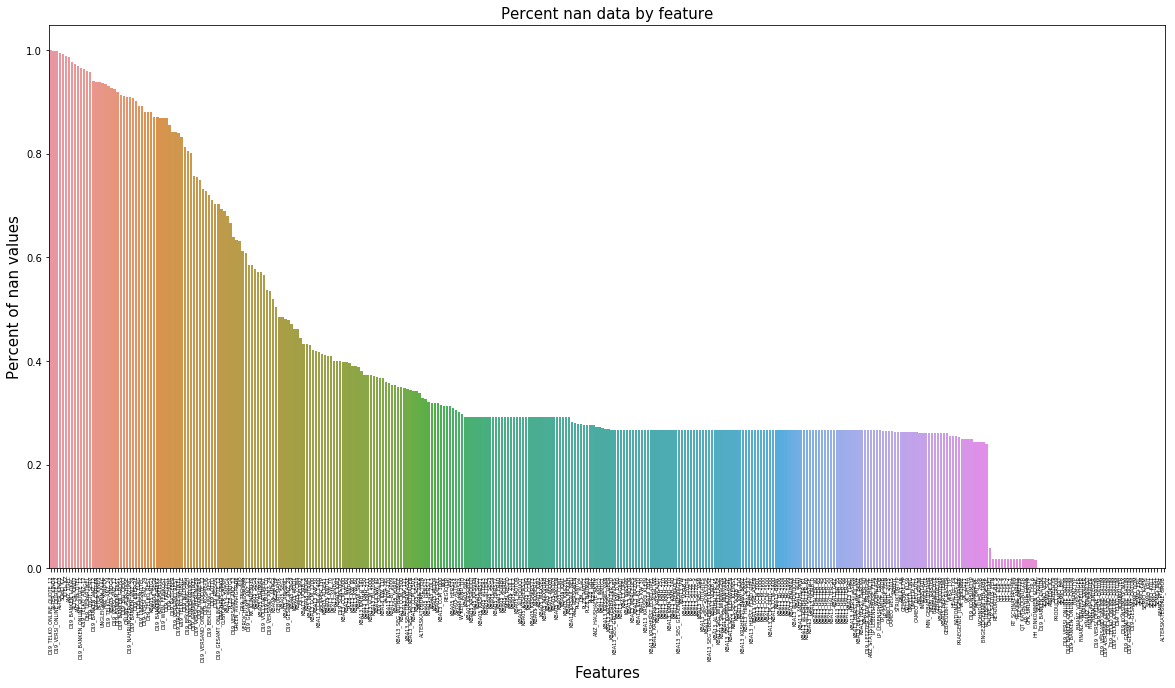

In [43]:
total = clean_customers.isna().sum().sort_values(ascending=False)
percent = (clean_customers.isna().sum()/clean_customers.isna().count()).sort_values(ascending=False)
nan_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(20, 10))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(5)

    plt.xticks(rotation='90')
sns.barplot(x=nan_data.index, y=nan_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of nan values', fontsize=15)
plt.title('Percent nan data by feature', fontsize=15)

nan_data.head()

##### V. Dropping columns with more than 10% of NaN values

In [54]:
clean_customers_dropna = clean_customers.loc[:, pd.notnull(clean_customers).sum()>len(clean_customers)*.9]

In [55]:
clean_customers_dropna.columns, len(clean_customers_dropna.columns)

(Index(['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SE

In [56]:
clean_customers_dropna.shape

(191652, 58)

##### VII. Replacing remaining NaNs with -1 value

In [60]:
clean_customers_fillna = clean_customers_dropna.fillna(-1)

##### VIII. Checking data type and cleaned values

In [61]:
# Counting NaN values for each column
clean_customers_fillna.apply(lambda x:x.isna().sum())

CJT_GESAMTTYP                0
CJT_KATALOGNUTZER            0
CJT_TYP_1                    0
CJT_TYP_2                    0
CJT_TYP_3                    0
CJT_TYP_4                    0
CJT_TYP_5                    0
CJT_TYP_6                    0
D19_BANKEN_DATUM             0
D19_BANKEN_OFFLINE_DATUM     0
D19_BANKEN_ONLINE_DATUM      0
D19_GESAMT_DATUM             0
D19_GESAMT_OFFLINE_DATUM     0
D19_GESAMT_ONLINE_DATUM      0
D19_KONSUMTYP_MAX            0
D19_TELKO_DATUM              0
D19_TELKO_OFFLINE_DATUM      0
D19_TELKO_ONLINE_DATUM       0
D19_VERSAND_DATUM            0
D19_VERSAND_OFFLINE_DATUM    0
D19_VERSAND_ONLINE_DATUM     0
D19_VERSI_DATUM              0
D19_VERSI_OFFLINE_DATUM      0
D19_VERSI_ONLINE_DATUM       0
FINANZ_ANLEGER               0
FINANZ_HAUSBAUER             0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_UNAUFFAELLIGER        0
FINANZ_VORSORGER             0
FINANZTYP                    0
GFK_URLAUBERTYP              0
HH_EINKO

In [62]:
# Data types
set(clean_customers_fillna.dtypes)

{dtype('int64'), dtype('float64')}

##### IX. Normalizing the data

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

customers_scaled = pd.DataFrame(scaler.fit_transform(clean_customers_fillna.astype(float)))
customers_scaled.index = clean_customers_fillna.index
customers_scaled.columns = clean_customers_fillna.columns

### Save cleaned data as pickle file

In [64]:
customers_scaled.to_pickle("cleaned_customers.pkl")

### 3- Data Visualization

In [76]:
customers_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 1 to 191652
Data columns (total 58 columns):
CJT_GESAMTTYP                191652 non-null float64
CJT_KATALOGNUTZER            191652 non-null float64
CJT_TYP_1                    191652 non-null float64
CJT_TYP_2                    191652 non-null float64
CJT_TYP_3                    191652 non-null float64
CJT_TYP_4                    191652 non-null float64
CJT_TYP_5                    191652 non-null float64
CJT_TYP_6                    191652 non-null float64
D19_BANKEN_DATUM             191652 non-null float64
D19_BANKEN_OFFLINE_DATUM     191652 non-null float64
D19_BANKEN_ONLINE_DATUM      191652 non-null float64
D19_GESAMT_DATUM             191652 non-null float64
D19_GESAMT_OFFLINE_DATUM     191652 non-null float64
D19_GESAMT_ONLINE_DATUM      191652 non-null float64
D19_KONSUMTYP_MAX            191652 non-null float64
D19_TELKO_DATUM              191652 non-null float64
D19_TELKO_OFFLINE_DATUM      191652 non-n

In [74]:
customers_scaled.describe()

,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,PRODUCT_GROUP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,0.657072,0.820992,0.600665,0.581500,0.903981,0.887422,0.904569,0.907663,0.929733,0.985164,...,0.421376,0.360980,0.518798,0.457023,0.319860,0.530880,0.315361,0.510363,0.376432,0.257613
std,0.270904,0.251845,0.267220,0.268327,0.186631,0.205276,0.189334,0.188392,0.182585,0.085806,...,0.248986,0.219370,0.345160,0.286340,0.203204,0.394568,0.233697,0.343986,0.484492,0.135782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.428571,0.666667,0.333333,0.333333,0.833333,0.833333,0.833333,0.833333,1.000000,1.000000,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.500000,0.000000,0.250000
50%,0.714286,1.000000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,0.333333,0.500000,0.333333,0.333333,0.666667,0.400000,0.500000,0.000000,0.250000
75%,1.000000,1.000000,0.833333,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.666667,0.500000,1.000000,0.833333,0.500000,0.833333,0.400000,0.500000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### I. Histogram

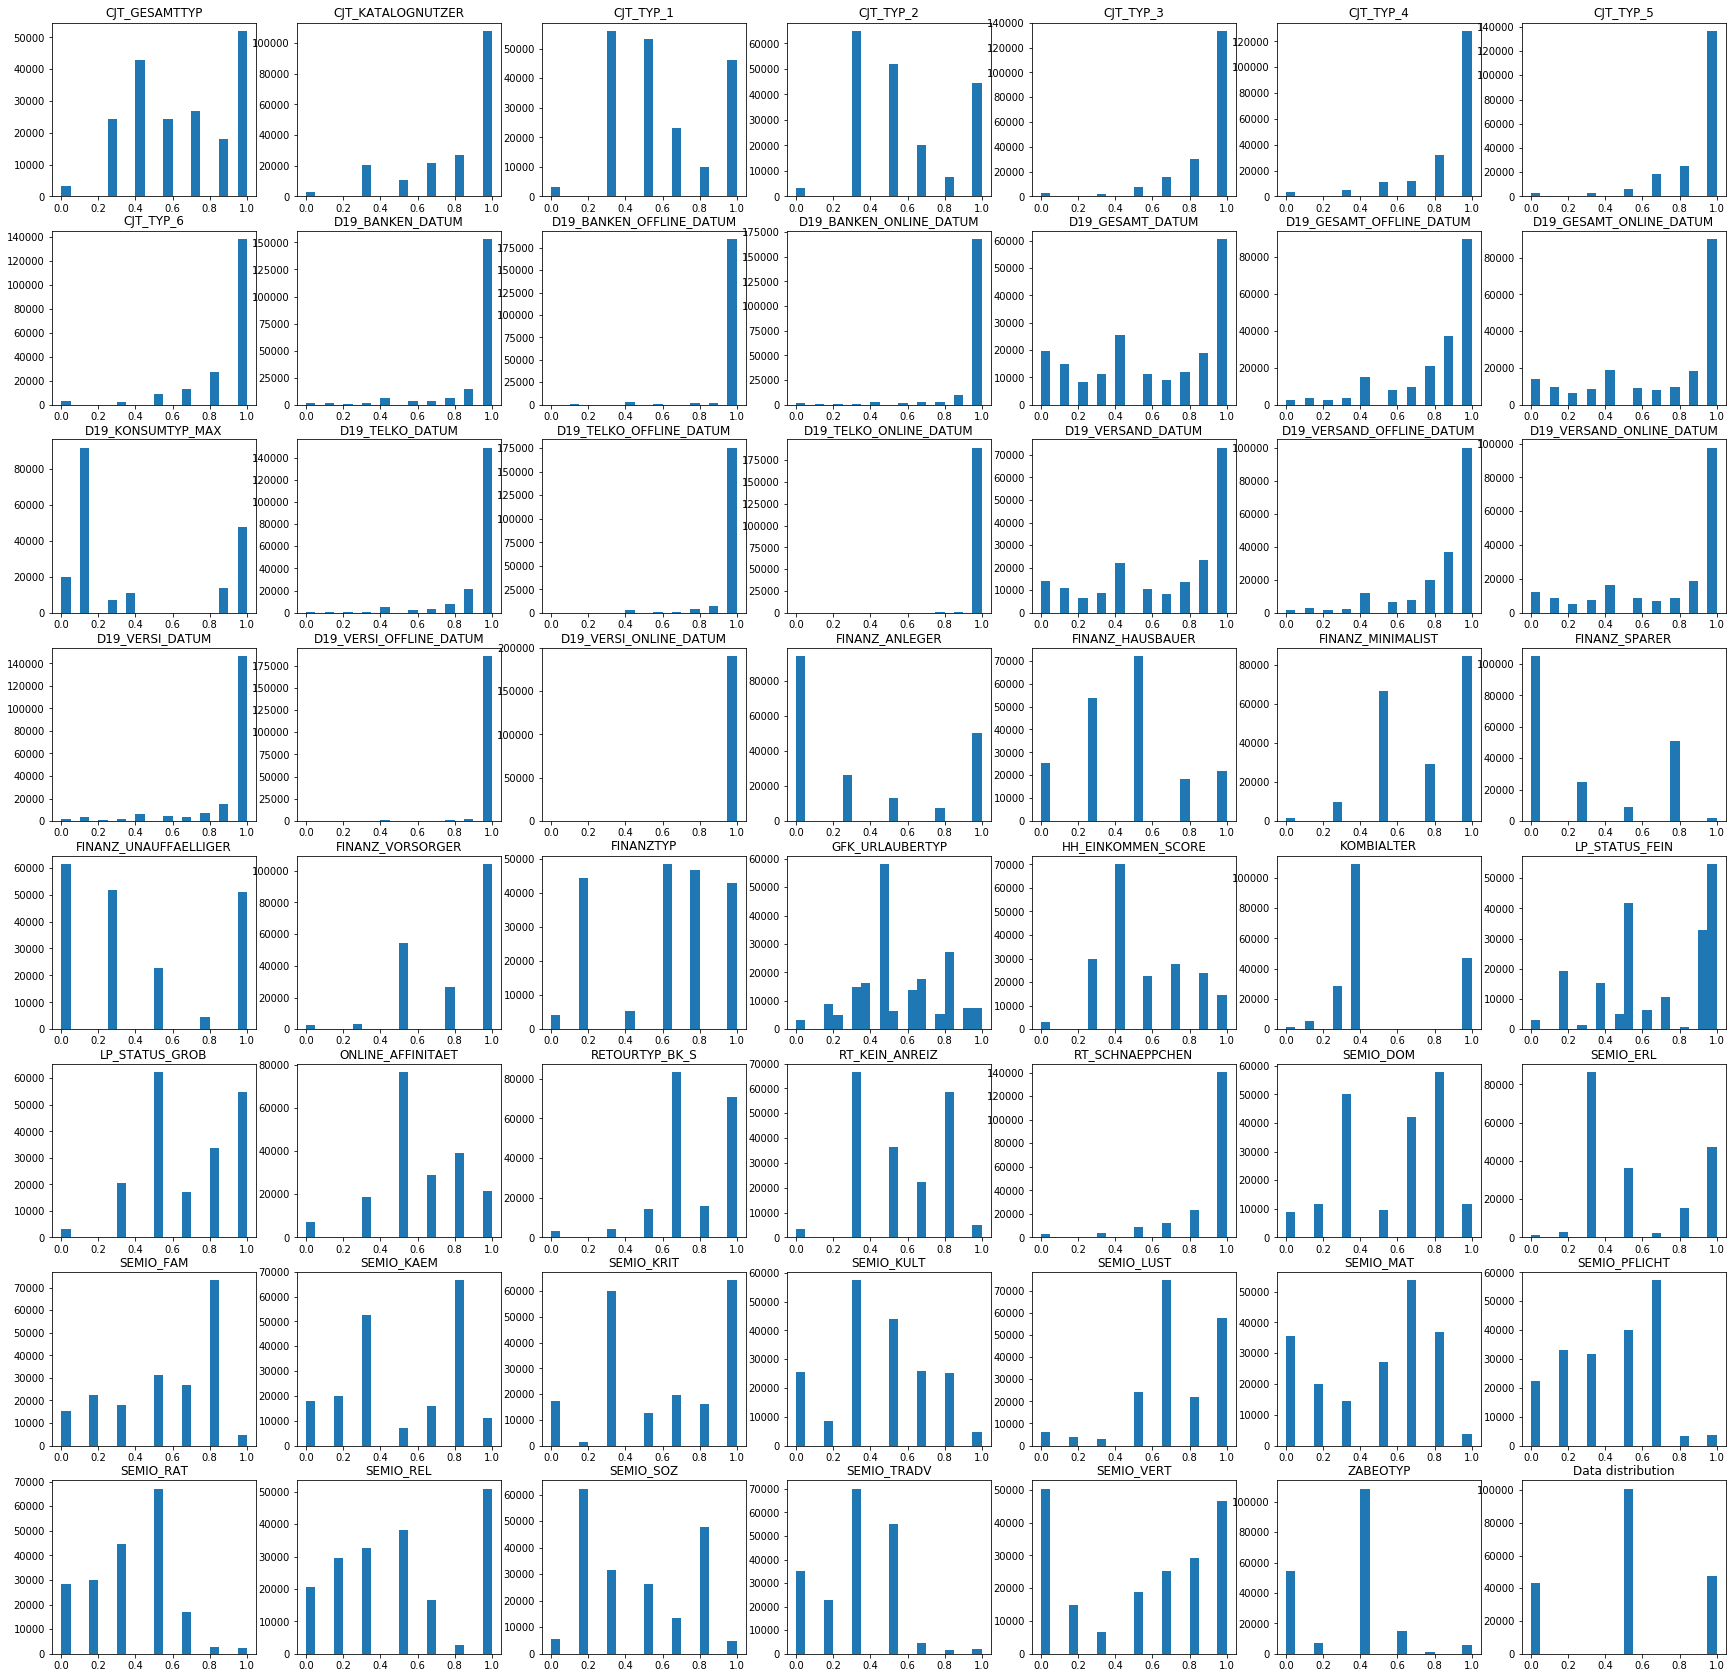

In [72]:
fig, axs = plt.subplots(8,7, figsize = (30,30))
axs = axs.flatten()

for i,name in list(zip(range(len(axs)),customers_scaled.columns[:len(axs)])):
    axs[i].set_title(name)
    axs[i].hist(customers_scaled[name], bins=10)
plt.title ('Data distribution')
plt.show()

##### II. Correlation matrix heatmap

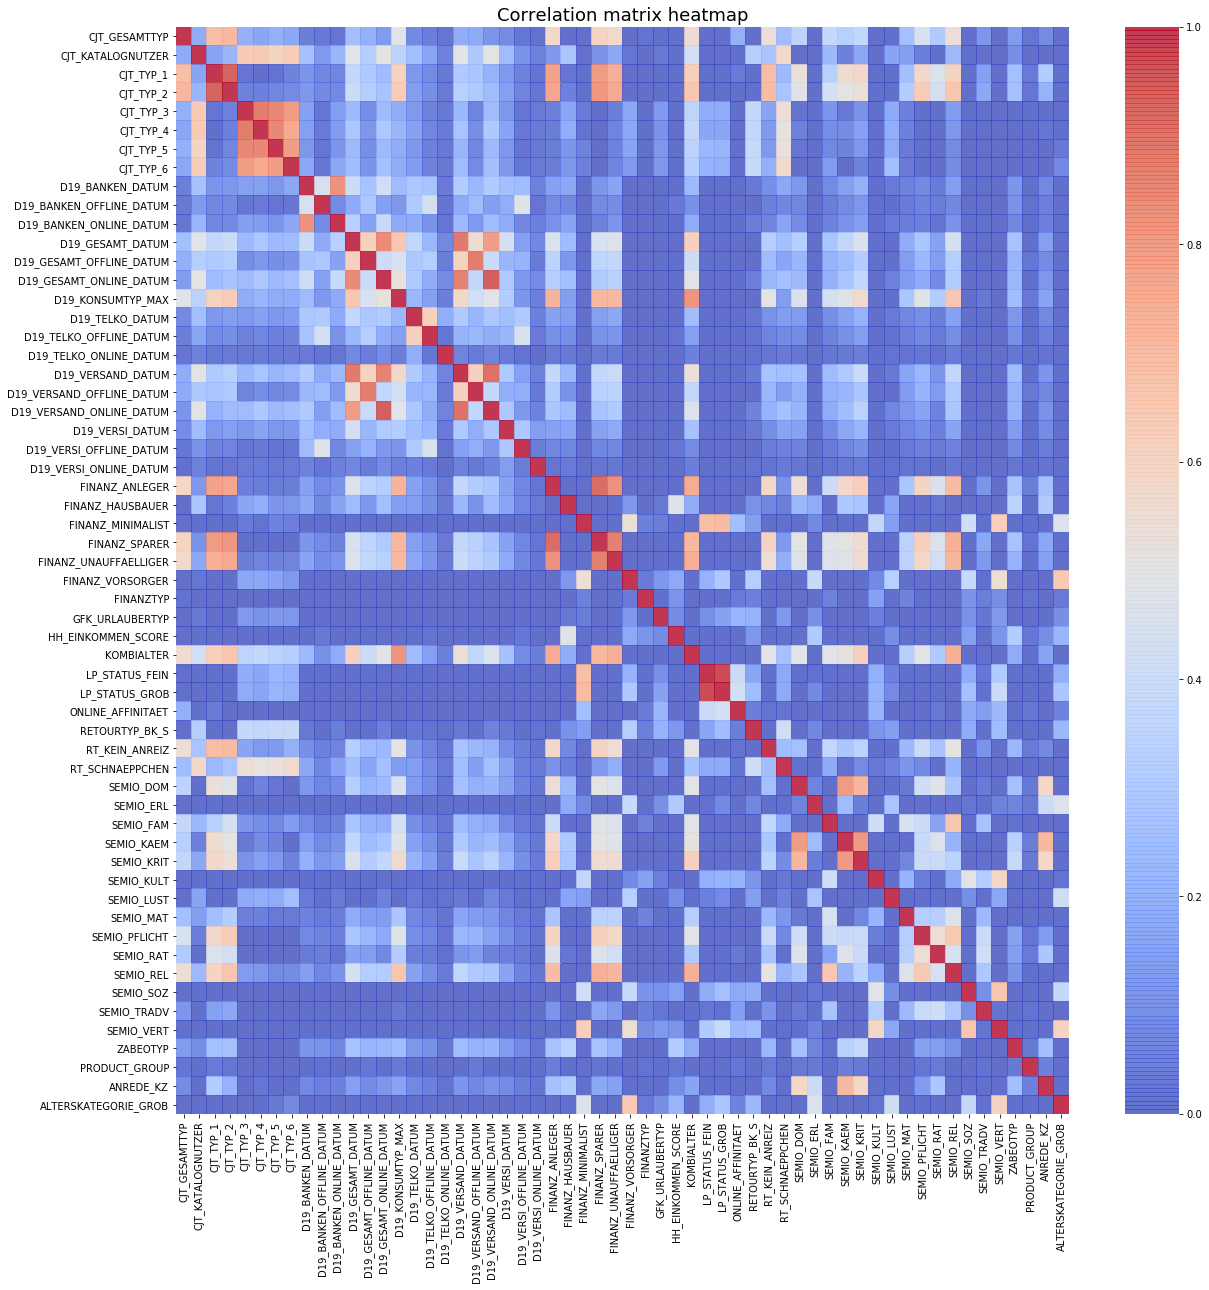

In [73]:
plt.figure(figsize=(15,15))
plt.title('Correlation matrix heatmap', fontsize=18)
sns.heatmap(customers_scaled.corr(), vmin=0, vmax=1, cmap="coolwarm", alpha=0.8);

### 4- Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a technique which uses sophisticated mathematical principles to transforms a number of possibly correlated variables into a smaller number of variables called principal components. The origins of PCA lie in [multivariate data analysis](https://is.muni.cz/el/1423/podzim2017/PSY028/um/_Hair_-_Multivariate_data_analysis_7th_revised.pdf-), however, it has a wide range of other applications. One of the most important and perhaps its most common use is as to reduce dimensionality of large data sets. First, we have a look the cleaned dataset and its features descriptions. Then we build our PCA model using Scikitlearn module [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [3]:
# Read preprocessed customers data
customers_scaled = pd.read_pickle("cleaned_customers.pkl")

In [4]:
customers_scaled.shape

(191652, 58)

In [5]:
# Intersection between customers dataframe and attributes dataframe
intersection_attributes = list(set(customers_scaled.columns).intersection(attributes.Attribute))

In [6]:
list_description = []
print ('The cleaned and scaled customers dataframe attributes are described as follows: \n')
for i in intersection_attributes:
    description = attributes[attributes['Attribute']== i]['Description'].values[0]
    list_description.append(description)
    print ('{} : {}'.format(i, description))

The cleaned and scaled customers dataframe attributes are described as follows: 

FINANZTYP : best descirbing financial type for the person
FINANZ_UNAUFFAELLIGER : financial typology: unremarkable
GFK_URLAUBERTYP : vacation habits
HH_EINKOMMEN_SCORE : estimated household net income 
SEMIO_MAT : affinity indicating in what way the person is material minded
SEMIO_DOM : affinity indicating in what way the person is dominant minded
D19_VERSAND_OFFLINE_DATUM : actuality of the last transaction for the segment mail-order OFFLINE
FINANZ_SPARER : financial typology: money saver
D19_GESAMT_OFFLINE_DATUM : actuality of the last transaction with the complete file OFFLINE
LP_STATUS_FEIN : social status fine
ONLINE_AFFINITAET : online affinity
LP_STATUS_GROB : social status rough
SEMIO_SOZ : affinity indicating in what way the person is social minded
SEMIO_RAT : affinity indicating in what way the person is of a rational mind
SEMIO_TRADV : affinity indicating in what way the person is traditional m

In [7]:
len(list_description)

43

43 features out of 58 are described in the cleaned data frame. In order to understand the data These features descriptions should be provided by Arvato Financials. Here below the missing features that are not described are listed.

In [25]:
no_desc_list = list(set(customers_scaled.columns)^set(intersection_attributes))

In [28]:
print ('List of features with no description: ')
no_desc_list

List of features with no description: 


['D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'KOMBIALTER',
 'D19_KONSUMTYP_MAX',
 'CJT_TYP_6',
 'RT_SCHNAEPPCHEN',
 'CJT_TYP_4',
 'PRODUCT_GROUP',
 'CJT_KATALOGNUTZER',
 'D19_VERSI_ONLINE_DATUM',
 'RT_KEIN_ANREIZ',
 'CJT_TYP_2',
 'CJT_TYP_5',
 'CJT_TYP_3',
 'CJT_TYP_1']

In [8]:
from sklearn.decomposition import PCA

In [9]:
def dim_reduction(df, pca):
    '''Reduce dimensionality of data using pca decomposition.
       :param df: Normalized customer dataframe; 
       :param pca: principal component analysis.
       return reduced dataframe and pca model
       '''
    
    min_features = df.shape[1]-1
    pca = pca(n_components=min_features)
    pca.fit(df)
    reduced = pca.transform(df)
    columns = ['c_{}'.format(i) for i in range(min_features)]
    print ('The dataframe has {} features and it is reduced to {}'.format(df.shape[1],min_features))
    
    return pd.DataFrame(data=reduced, columns=columns, index=df.index),pca

In [10]:
reduced_df,pca = dim_reduction(customers_scaled, pca=PCA)

The dataframe has 58 features and it is reduced to 57


##### Data Variance

Our PCA model creates 57 principal components, however we will select top_n components to capture a defined explained variance set here to 80%-90%. The top_n components value is determined by using pca attribute [pca.explained_variance_ratio_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Thereafter we will analyse the impact (weight) of each feature on each component using pca.components_ provided by sklearn module.

In [11]:
reduced_df.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54,c_55,c_56
LNR,,,,,,,,,,,,,,,,,,,,,
1,-1.550204,-0.557762,0.284860,-0.236605,-0.683383,0.525076,-0.263785,-0.567009,0.291954,-0.011845,...,-0.052178,0.035754,-0.009842,0.019450,-0.011224,-0.065701,0.040215,0.015312,0.059683,0.002694
2,-0.758681,-0.414917,-0.331124,-0.203730,0.260336,-0.490947,0.581229,-0.130825,0.241708,-0.353270,...,0.000157,-0.068129,0.007019,0.005809,0.013509,0.056929,-0.064086,-0.015050,0.047000,-0.007976
3,-0.339375,1.456063,-0.467796,0.190606,-0.435254,-0.417612,-0.032688,0.073924,0.527064,-0.028801,...,0.005650,0.132413,-0.072577,0.034101,0.162671,-0.181905,-0.023458,-0.219635,-0.024614,-0.004012
4,-0.899230,-0.534147,-0.372054,-0.152742,0.238905,0.023095,-0.193726,0.201659,0.350126,-0.208103,...,-0.062304,0.073992,0.096265,-0.029923,0.057929,0.020407,-0.017950,0.011112,0.048144,-0.001353
5,0.113870,1.122220,-0.418172,-0.385525,0.455118,-0.039998,0.162142,-0.656677,-0.159017,0.084114,...,0.004998,-0.013493,0.068899,0.050567,-0.025935,0.012506,-0.004491,-0.004165,0.008042,0.000672


In [12]:
print ('The make up of principal components: \n' )
print (pca.components_)
print ('has {} rows '.format(pca.components_.shape[0]))
print ('and {} columns '.format(pca.components_.shape[1]))

The make up of principal components: 

[[  1.31977983e-01   6.76482115e-02   1.76070561e-01 ...,   5.43023956e-03
    1.48750658e-01  -8.14201538e-02]
 [ -9.06869504e-02  -4.95309571e-02  -2.77212312e-02 ...,   2.25335415e-02
    5.44317699e-01   4.38878264e-02]
 [  1.06810512e-01  -2.30093128e-01   1.34473504e-01 ...,   3.54540050e-02
    1.19532261e-01  -5.41329149e-02]
 ..., 
 [ -2.05273897e-03  -1.37014429e-03  -2.66236488e-02 ...,  -8.31065657e-04
    2.55623494e-04  -3.93990572e-03]
 [ -3.87424516e-03  -1.30991584e-02   4.65293616e-03 ...,   2.30687729e-04
   -1.08956265e-03  -7.16990294e-03]
 [ -3.26849683e-04   2.13375676e-04  -1.14560644e-03 ...,   2.63455155e-04
    7.04430325e-05   3.21645352e-04]]
has 57 rows 
and 58 columns 


In [13]:
print ('The explained variance ratio of principal components: \n' )
print (pca.explained_variance_ratio_)
print ('has {} sorted elements '.format(pca.explained_variance_ratio_.shape[0]))

The explained variance ratio of principal components: 

[  3.48317902e-01   1.23104688e-01   1.04255750e-01   5.46015131e-02
   3.78044589e-02   2.82398542e-02   2.34650497e-02   2.24661192e-02
   2.15858845e-02   1.78484261e-02   1.61575845e-02   1.24485248e-02
   1.21536884e-02   1.09366503e-02   1.04444564e-02   1.00595038e-02
   9.54100120e-03   9.06511477e-03   8.78198342e-03   8.18355906e-03
   7.65235639e-03   7.13395827e-03   7.02256600e-03   6.44609892e-03
   5.70134407e-03   5.16617721e-03   5.15258372e-03   5.00957685e-03
   4.83754736e-03   4.57544300e-03   4.36224361e-03   4.26889105e-03
   3.94376245e-03   3.43653892e-03   3.42720920e-03   3.25554009e-03
   3.06904243e-03   2.97027133e-03   2.70987587e-03   2.21556271e-03
   2.16891359e-03   1.98389568e-03   1.85538421e-03   1.56997676e-03
   1.33168987e-03   1.31644319e-03   1.26002563e-03   1.04194085e-03
   9.50912565e-04   9.31918251e-04   8.91518883e-04   6.75464900e-04
   6.14885184e-04   5.50457976e-04   4.31613570

##### Data variance vs dimensionality reduction

In this model we want to capture 80% to 90% of the explained variance and be able to reduce the dimensionality as much as we can. For this purpose we visualize the explained ratio vs top_n components to understand the situation.

We can distinguish the data variance starting from 35% (top_n=1) to 99% (top_n=57). The goal is to choose the best top_n value which is situated between 10 and 20 compnents where the slope start to decrease.

In [14]:
explained_variance_ratio = pca.explained_variance_ratio_

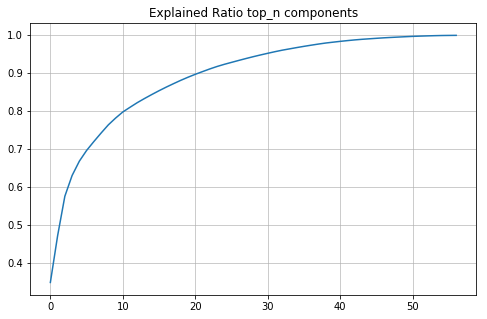

In [15]:
list_of_var_sums = []
top_n = 57
total_sum = 0
for i in range(len(explained_variance_ratio[:top_n])):
    total_sum = total_sum + explained_variance_ratio[i]
    list_of_var_sums.append(total_sum)
    
plt.figure(figsize=(8,5))
plt.title('Explained Ratio top_n components', fontsize=12)
plt.grid(alpha=0.8)
plt.plot(list_of_var_sums)
plt.show()

In [16]:
# The good top_n
top_n=12
print ('We retain {} components and capture {}% explained variance'\
       .format(top_n,(pca.explained_variance_ratio_[:top_n].sum()*100).round(2)))

We retain 12 components and capture 81.03% explained variance


##### Component Makeup

Once we have determine the top_n components, we want to visualize the makeup of each PCA component based on the weightings of the original features that are included in the component. To make it possible we create a function to display ascending n_weights features in th component.


In [17]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = 57-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [18]:
# Creating components dataframe
comp = pca.components_
v = pd.DataFrame(data=comp)

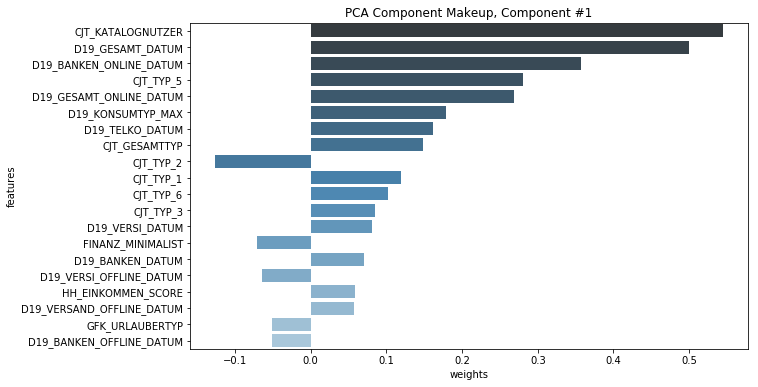

In [19]:
# Display makeup of first component
num=1
display_component(v, customers_scaled.columns.values, component_num=num, n_weights=20)

In [20]:
columns = ['c_{}'.format(i) for i in range(top_n)]
reduced_df = reduced_df[columns]
reduced_df.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
LNR,,,,,,,,,,,,
1,-1.550204,-0.557762,0.284860,-0.236605,-0.683383,0.525076,-0.263785,-0.567009,0.291954,-0.011845,0.426989,0.155004
2,-0.758681,-0.414917,-0.331124,-0.203730,0.260336,-0.490947,0.581229,-0.130825,0.241708,-0.353270,-0.038268,-0.214118
3,-0.339375,1.456063,-0.467796,0.190606,-0.435254,-0.417612,-0.032688,0.073924,0.527064,-0.028801,0.322473,-0.106870
4,-0.899230,-0.534147,-0.372054,-0.152742,0.238905,0.023095,-0.193726,0.201659,0.350126,-0.208103,0.328515,-0.153358
5,0.113870,1.122220,-0.418172,-0.385525,0.455118,-0.039998,0.162142,-0.656677,-0.159017,0.084114,-0.156011,0.081334


In [21]:
reduced_df.to_pickle("reduced_customers.pkl")

## 5- Clustering Analysis

Cluster analysis is a group of multivariate techniques whose primary purpose is to group objects based
on the characteristics they possess.
Cluster analysis differs from factor analysis, however, in that
cluster analysis groups objects, whereas factor analysis is primarily concerned with grouping variables. Additionally, factor analysis makes the groupings based on patterns of variation (correlation) in
the data whereas cluster analysis makes groupings on the basis of distance (proximity).

Cluster analysis classifies objects (e.g., respondents, products, or other entities), on a set of user
selected characteristics. The resulting clusters should exhibit high internal (within-cluster) homogeneity and high external (between-cluster) heterogeneity. 

## Conceptual Support in Cluster Analysis

Cluster analysis will always create clusters, regardless of the actual existence of any structure
in the data. When using cluster analysis, the researcher is making an assumption of some
structure among the objects. The researcher should always remember that just because
clusters can be found does not validate their existence. Only with strong conceptual support
and then validation are the clusters potentially meaningful and relevant.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')